In [113]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
import torch.optim as optim
!pip install torchsummary
from torchsummary import summary

In [114]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [115]:
with open('/kaggle/input/popular-names/names.txt','r') as file:
    data = file.read().split('\n')

In [116]:
data[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [117]:
train_data = data[:int(len(data)*0.8)]
val_data = data[int(len(data)*0.8):int(len(data)*0.9)]
test_data = data[int(len(data)*0.9):int(len(data))]

In [118]:
print(len(train_data) , len(val_data) , len(test_data))

25626 3203 3204


**dataset**
*the below function create a dataset given data and chuck size (here a chunck mean how  many char given to predict the next char)*

In [119]:
def makedataset(data,chunck):
    x = []
    y = []
    dummy=''
    for i in range(chunck):
        dummy+='.'
    for word in data:
        word = dummy + word + '.'
        for i in range(len(word)-chunck-1):
            x.append(word[i:i+chunck])
            y.append(word[i+chunck])
    return x , y

In [120]:
x , y = makedataset(train_data,4)

**use some type maping to make them into number so that we can do operations on them**

*one way is one hot encodding where echar will be represented by a list of size with vocublary length*
*othre way is we can represent each char into a lower dimensional vector which helps in increasing computaional speed and data requriments*

In [121]:
hashmap = {}
for i , ch in enumerate(range(97,123)):
    hashmap[chr(ch)] = i
hashmap['.']=26
hashmap

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '.': 26}

In [122]:
x_num = []
y_num = []
for i in range(len(x)):
    tmp = []
    for ch in x[i]:
        tmp.append(hashmap[ch])
    y_num.append(hashmap[y[i]])
    x_num.append(tmp)

In [123]:
x_num[0:5]

[[26, 26, 26, 26],
 [26, 26, 26, 4],
 [26, 26, 4, 12],
 [26, 4, 12, 12],
 [26, 26, 26, 26]]

In [124]:
y_num[0:5]

[4, 12, 12, 0, 14]

In [125]:
x_num = torch.tensor(x_num).to(device)
y_num = torch.tensor(y_num).to(device)

In [126]:
x_num.shape
print(x_num[:10])

tensor([[26, 26, 26, 26],
        [26, 26, 26,  4],
        [26, 26,  4, 12],
        [26,  4, 12, 12],
        [26, 26, 26, 26],
        [26, 26, 26, 14],
        [26, 26, 14, 11],
        [26, 14, 11,  8],
        [14, 11,  8, 21],
        [11,  8, 21,  8]], device='cuda:0')


In [127]:
y_num.shape
print(y_num[:10])

tensor([ 4, 12, 12,  0, 14, 11,  8, 21,  8,  0], device='cuda:0')


**approach**
1. *a trigram laungauge model is a model where it take input of 3 sequence characters and predicts the next char in the sequence*
2. *this can be used as document filling model*
3. *here i will be implementing a trigram model with wavenet architecture*  

*input after will be (3,3) encoded vector out put will be a softmax of dim->(27,1) each giving probs of each char*
*considering batch size input will be (batch_size , 3) -> (batch_size,3,3) -> (batch_size,9) -> *

In [128]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embed = nn.Embedding(27,4).to(device)
        self.linear64 = nn.Linear(16,64)
#         self.norm1= nn.BatchNorm1d(2)
        self.nonlinear = nn.Tanh()
        self.linear256 = nn.Linear(64,256)
#         self.norm2=nn.BatchNorm1d(1)
        self.linear128 =nn.Linear(256,128)
#         self.norm3 = nn.BatchNorm1d(1)
        self.linear = nn.Linear(128,27)
        self.logits = nn.LogSoftmax(dim=1)
    def forward(self,x):
        # 64 , 4 ,4
        x = self.embed(x)
        x = x.view(-1,16)
        x = self.linear64(x)
        x = self.nonlinear(x)
#         x = self.norm1(x)
#         x = x.view(64,1,128)
        x = self.linear256(x)
        x = self.nonlinear(x)
#         x = self.norm2(x)
        # 64 1 256
        x = self.linear128(x)
        x = self.nonlinear(x)
#         x = self.norm3(x)
        x = self.linear(x)
        x = self.logits(x)
        return x

In [129]:
class textset(Dataset):
    def __init__(self,x_num,y_num):
        self.x=x_num
        self.y=y_num
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        x=self.x[idx]
        y=self.y[idx]
        return x.to(device) , y.to(device)

In [130]:
data = textset(x_num,y_num)

In [131]:
loader = DataLoader(data,batch_size=64)

In [132]:
trigram = Model().to(device)

In [133]:
trigram.to(device)

Model(
  (embed): Embedding(27, 4)
  (linear64): Linear(in_features=16, out_features=64, bias=True)
  (nonlinear): Tanh()
  (linear256): Linear(in_features=64, out_features=256, bias=True)
  (linear128): Linear(in_features=256, out_features=128, bias=True)
  (linear): Linear(in_features=128, out_features=27, bias=True)
  (logits): LogSoftmax(dim=1)
)

In [134]:
optimizer = optim.Adam(trigram.parameters(),lr=0.001)

In [164]:
trigram.train()

Model(
  (embed): Embedding(27, 4)
  (linear64): Linear(in_features=16, out_features=64, bias=True)
  (nonlinear): Tanh()
  (linear256): Linear(in_features=64, out_features=256, bias=True)
  (linear128): Linear(in_features=256, out_features=128, bias=True)
  (linear): Linear(in_features=128, out_features=27, bias=True)
  (logits): LogSoftmax(dim=1)
)

In [136]:
criterion = nn.NLLLoss()

In [137]:
criterion.to(device)

NLLLoss()

In [138]:
trigram.to(device)

Model(
  (embed): Embedding(27, 4)
  (linear64): Linear(in_features=16, out_features=64, bias=True)
  (nonlinear): Tanh()
  (linear256): Linear(in_features=64, out_features=256, bias=True)
  (linear128): Linear(in_features=256, out_features=128, bias=True)
  (linear): Linear(in_features=128, out_features=27, bias=True)
  (logits): LogSoftmax(dim=1)
)

In [139]:
x_tmp = x_num[0:64]
x_tmp.to(device)

tensor([[26, 26, 26, 26],
        [26, 26, 26,  4],
        [26, 26,  4, 12],
        [26,  4, 12, 12],
        [26, 26, 26, 26],
        [26, 26, 26, 14],
        [26, 26, 14, 11],
        [26, 14, 11,  8],
        [14, 11,  8, 21],
        [11,  8, 21,  8],
        [26, 26, 26, 26],
        [26, 26, 26,  0],
        [26, 26,  0, 21],
        [26, 26, 26, 26],
        [26, 26, 26,  8],
        [26, 26,  8, 18],
        [26,  8, 18,  0],
        [ 8, 18,  0,  1],
        [18,  0,  1,  4],
        [ 0,  1,  4, 11],
        [ 1,  4, 11, 11],
        [26, 26, 26, 26],
        [26, 26, 26, 18],
        [26, 26, 18, 14],
        [26, 18, 14, 15],
        [18, 14, 15,  7],
        [14, 15,  7,  8],
        [26, 26, 26, 26],
        [26, 26, 26,  2],
        [26, 26,  2,  7],
        [26,  2,  7,  0],
        [ 2,  7,  0, 17],
        [ 7,  0, 17, 11],
        [ 0, 17, 11, 14],
        [17, 11, 14, 19],
        [11, 14, 19, 19],
        [26, 26, 26, 26],
        [26, 26, 26, 12],
        [26,

In [140]:
y_tmp = y_num[0:64]
y_tmp.to(device)

tensor([ 4, 12, 12,  0, 14, 11,  8, 21,  8,  0,  0, 21,  0,  8, 18,  0,  1,  4,
        11, 11,  0, 18, 14, 15,  7,  8,  0,  2,  7,  0, 17, 11, 14, 19, 19,  4,
        12,  8,  0,  0, 12,  4, 11,  8,  0,  7,  0, 17, 15,  4, 17,  4, 21,  4,
        11, 24, 13,  0,  1,  8,  6,  0,  8, 11], device='cuda:0')

In [165]:
epochs = 2000
losses = []
for i in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    pred = trigram(x_num)
    loss = criterion(pred.to(device),y_num)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
#     i=0
#     for x , y in tqdm(loader):
#         optimizer.zero_grad()
#         pred = trigram(x)
#         loss = criterion(pred.to(device),y)
#         loss.backward()
#         optimizer.step()
#         running_loss+=loss.item()
#         i+=1    
#     print(f"loss at {i}th epoch is : {running_loss}")
    losses.append(running_loss)

In [168]:
print(losses)

[2.0089316368103027, 2.0088295936584473, 2.0087180137634277, 2.008615016937256, 2.008504629135132, 2.008394718170166, 2.008296251296997, 2.0081918239593506, 2.008082628250122, 2.0079784393310547, 2.0078845024108887, 2.007781982421875, 2.007680892944336, 2.007582902908325, 2.007481098175049, 2.007387638092041, 2.0072848796844482, 2.0071887969970703, 2.007093667984009, 2.006991147994995, 2.0069007873535156, 2.006808042526245, 2.0067107677459717, 2.0066168308258057, 2.006526470184326, 2.006429672241211, 2.0063364505767822, 2.006249189376831, 2.0061540603637695, 2.0060572624206543, 2.0059754848480225, 2.005880832672119, 2.005790948867798, 2.005706548690796, 2.005613088607788, 2.005526304244995, 2.005439281463623, 2.005345582962036, 2.0052616596221924, 2.0051748752593994, 2.005093812942505, 2.0050036907196045, 2.0049173831939697, 2.0048303604125977, 2.0047409534454346, 2.0046579837799072, 2.0045714378356934, 2.0044898986816406, 2.004399299621582, 2.004317045211792, 2.004239320755005, 2.0041

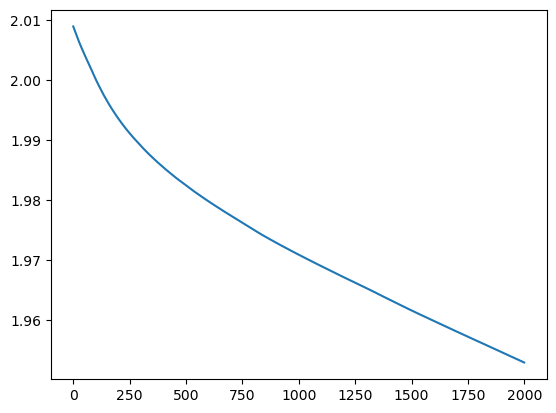

In [167]:
plt.plot(losses)

In [157]:
trigram.eval()
out = trigram(torch.tensor([1,2,3,4]).to(device))

In [163]:
out

tensor([[ -4.7051,  -4.9162,  -3.1665,  -2.9050,  -3.3837,  -5.0115,  -3.6866,
          -4.9442,  -5.0693,  -6.4279,  -5.7492,  -1.4236,  -4.4517,  -1.9847,
          -4.8031,  -4.7741,  -9.4537,  -2.1336,  -2.3339,  -2.4573,  -5.4464,
          -4.3635,  -3.4802,  -4.0600,  -3.5513,  -6.5367, -21.2078]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)